<a href="https://colab.research.google.com/github/MadHatter999/ALGO_LiDAR3.0/blob/main/Feature_Extraction_Gray_Level_Co_occurrence_Matrix_(GLCM)_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Nous utiliserons la bibliothèque 'os' pour lire les noms de fichiers des dossiers et la bibliothèque 'cv2' (OpenCV) pour faire le traitement d'image**

In [10]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
from PIL import Image , ImageDraw

In [11]:
def NoiseGenerator(height, width,number):#generer une image bruit
    for i in range (number):
        array = np.random.randint(255, size=(height, width),dtype=np.uint8)
        image = Image.fromarray(array)
        #image.show()
        nom=str(i)+".png" 
        image.save("/noise"+nom)

In [12]:
def decouper(image):#corp l'images en des morceaux 50*50
    width, height = image.size
    if height%50==0:
        i_max=height//50
    else:
        i_max=height//50+1

    if width%50==0:
        j_max=width//50
    else:
        j_max=width//50+1

#im1 = im.crop((left, top, right, bottom)) 
    for i in range(i_max):
        for j in range(j_max):
            if i==i_max:
                if j==j_max:
                    croped= image.crop((50*j+1, 50*i+1, width,height)) 
                else:
                    croped= image.crop((50*j+1, 50*i+1,50*(j+1)+1 ,height)) 
            else:
                if j==j_max:
                    croped= image.crop((50*j+1, 50*i+1, width,50*(i+1)+1)) 
                else:
                    croped= image.crop((50*j+1, 50*i+1,50*(j+1)+1 ,50*(i+1)+1)) 
            nom=str(j+1)+"."+str(i+1)+".png"
            croped.save("images de bruit/"+nom)

In [13]:
def ecrire(text):#retourner une image contenant la valeur d'un des indices
    img = Image.new('RGB', (50,50), color = (255,255,255))
    d = ImageDraw.Draw(img)
    d.text((1,20), text, fill=(0,0,0))
    return(img)

In [14]:
def get_concat_h(im1, im2):#concatener 2 images horizontalement
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):#concatener 2 images verticalement
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst


In [9]:
import numpy as np 
import cv2 
import os
import re

# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder 
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")
        

# -------------------- Load Dataset ------------------------
 
dataset_dir = '/gdrive'

imgs = [] #list image matrix 
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1
        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            h, w = gray.shape
            ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
            crop = gray[ymin:ymax, xmin:xmax]
            
            resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)
            
            imgs.append(resize)
            labels.append(normalize_label(os.path.splitext(filename)[0]))
            descs.append(normalize_desc(folder, sub_folder))
            
            print_progress(i, len_sub_folder, folder, sub_folder, filename)

NotADirectoryError: ignored

**2) L'ensemble de données d'images de feuilles sera stocké dans la liste 'imgs' et les noms de feuilles seront stockés dans la liste 'labels'. Nous pouvons prévisualiser l'une des images de la manière suivante**

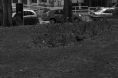

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(imgs[0])

**3) Ensuite, nous pouvons trouver la matrice GLCM et la métrique de texture globale de l'image de la feuille en utilisant les fonctions greycomatrix() et greycoprops() dans la bibliothèque Scikit-Image.**

In [ ]:
from skimage.feature import greycomatrix, greycoprops

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
columns.append("label")

**4) Ensuite, nous changeons le format de données glcm_features de liste en Dataframe à l'aide de la bibliothèque pandas**

In [ ]:
import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)
glcm_df['label'] = glcm_df['label'].astype(int)
sorted_df = glcm_df.sort_values(by=['label'], ascending=True)
sorted_df

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
3,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,40.761289,40.838905,40.925354,41.015884,0.015873,0.011329,0.020960,0.000029,0.025894,0.025267,...,2632.280465,0.000116,0.000121,0.000118,0.000118,0.010777,0.010995,0.010841,0.010876,11
5,39.125000,33.375000,50.875000,37.750000,0.175071,0.041717,-0.181790,0.250414,0.042368,0.101519,...,2558.500000,0.020833,0.033203,0.020833,0.031250,0.144338,0.182217,0.144338,0.176777,21
0,13.498298,16.502726,15.354539,15.866169,0.379110,0.114437,0.228608,0.208673,0.123990,0.104008,...,808.188122,0.001001,0.000911,0.000935,0.000933,0.031632,0.030189,0.030570,0.030540,51
1,6.441003,8.246918,8.565823,8.016596,0.904933,0.861387,0.866758,0.869166,0.252446,0.225886,...,289.689663,0.001989,0.001547,0.001389,0.001604,0.044593,0.039327,0.037265,0.040048,52
4,5.583333,9.875000,9.500000,7.375000,0.396437,-0.222699,-0.283472,0.145858,0.196180,0.072484,...,84.500000,0.023437,0.031250,0.020833,0.037109,0.153093,0.176777,0.144338,0.192638,55
